In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

## 컨브넷 필터 시각화

컨브넷이 학습한 필터를 조사하는 또 다른 간편한 방법은 각 필터가 반응하는 시각적 패턴을 그려보는 것입니다. 빈 입력 이미지에서 시작해서 특정 필터의 응답을 최대화하기 위해 컨브넷 입력 이미지에 경사 상승법을 적용합니다. 결과적으로 입력 이미지는 선택된 필터가 최대로 응답하는 이미지가 될 것입니다.

전체 과정은 간단합니다. 특정 합성곱 층의 한 필터의 값을 최대화하는 손실 함수를 정의합니다. 이 활성화 값을 최대화하기 위해 입력 이미지를 변경하도록 확률적 경사 상승법을 사용합니다. 예를 들어 여기에서는 ImageNet에 사전 훈련된 VGG16 네트워크에서 `block3_conv1` 층의 필터 0번의 활성화를 손실로 정의합니다:

In [1]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

Using TensorFlow backend.


경사 상승법을 구현하기 위해 모델의 입력에 대한 손실의 그래디언트가 필요합니다. 이를 위해 케라스의 `backend` 모듈에 있는 `gradients` 함수를 사용하겠습니다:

In [2]:
# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 첫 번째 텐서를 추출합니다
grads = K.gradients(loss, model.input)[0]

경사 상승법 과정을 부드럽게 하기 위해 사용하는 한 가지 기법은 그래디언트 텐서를 L2 노름(텐서에 있는 값을 제곱합의 제곱근)으로 나누어 정규화하는 것입니다. 이렇게 하면 입력 이미지에 적용할 수정량의 크기를 항상 일정 범위 안에 놓을 수 있습니다.

In [3]:
# 0 나눗셈을 방지하기 위해 1e–5을 더합니다
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

이제 주어진 입력 이미지에 대해 손실 텐서와 그래디언트 텐서를 계산해야 합니다. 케라스 백엔드 함수를 사용하여 처리하겠습니다. `iterate`는 넘파이 텐서(크기가 1인 텐서의 리스트)를 입력으로 받아 손실과 그래디언트 두 개의 넘파이 텐서를 반환합니다.

In [4]:
iterate = K.function([model.input], [loss, grads])

# 테스트:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

여기에서 파이썬 루프를 만들어 확률적 경사 상승법을 구성합니다:

In [5]:
# 잡음이 섞인 회색 이미지로 시작합니다
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 업데이트할 그래디언트의 크기
step = 1.
for i in range(40):   # 경사 상승법을 40회 실행합니다
    # 손실과 그래디언트를 계산합니다
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지를 수정합니다
    input_img_data += grads_value * step

결과 이미지 텐서는 `(1, 150, 150, 3)` 크기의 부동 소수 텐서입니다. 이 텐서의 값은 `[0, 255]` 사이의 정수가 아닙니다. 따라서 출력 가능한 이미지로 변경하기 위해 후처리할 필요가 있습니다. 이를 위해 간단한 함수를 정의해 사용하겠습니다:

In [6]:
def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

이제 모든 코드가 준비되었습니다. 이 코드를 모아서 층의 이름과 필터 번호를 입력으로 받는 함수를 만들겠습니다. 이 함수는 필터 활성화를 최대화하는 패턴을 이미지 텐서로 출력합니다:

In [7]:
def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

이 함수를 실행해 보죠:

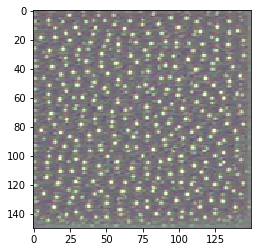

In [9]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

`block3_conv1` 층의 필터 0은 물방울 패턴에 반응하는 것 같습니다.

이제 재미있는 것을 만들어 보죠. 모든 층에 있는 필터를 시각화해보겠습니다. 간단하게 만들기 위해 각 층에서 처음 64개의 필터만 사용하겠습니다. 또 각 합성곱 블럭의 첫 번째 층만 살펴보겠습니다(`block1_conv1`, `block2_conv1`, `block3_conv1`, `block4_conv1`, `block5_conv1`). 여기서 얻은 출력을 64 × 64 필터 패턴의 8 × 8 그리드로 정렬합니다. 각 필터 패턴 사이에 검은 색 마진을 약간 둡니다.

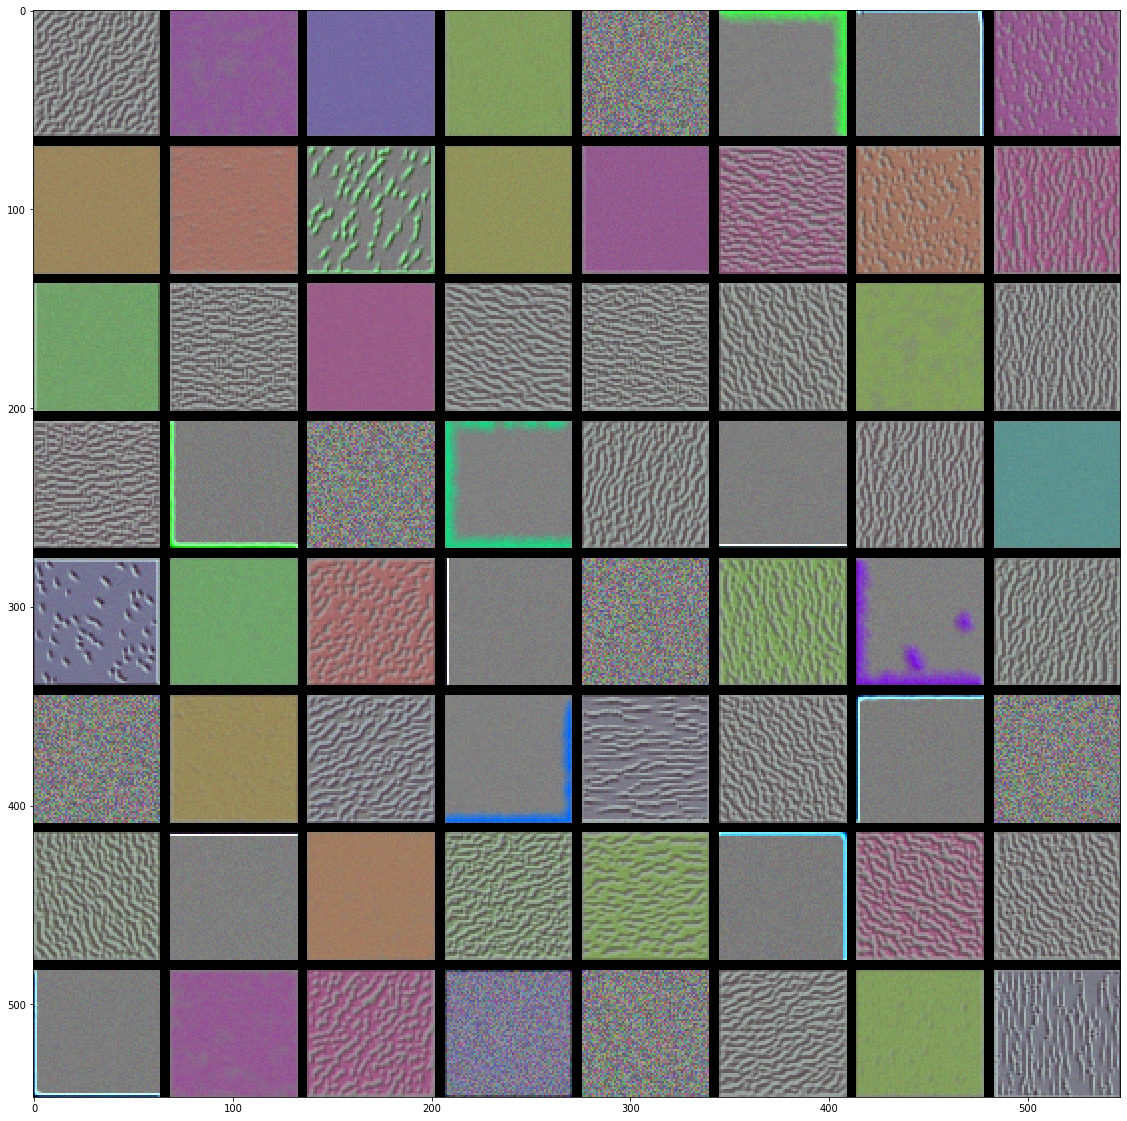

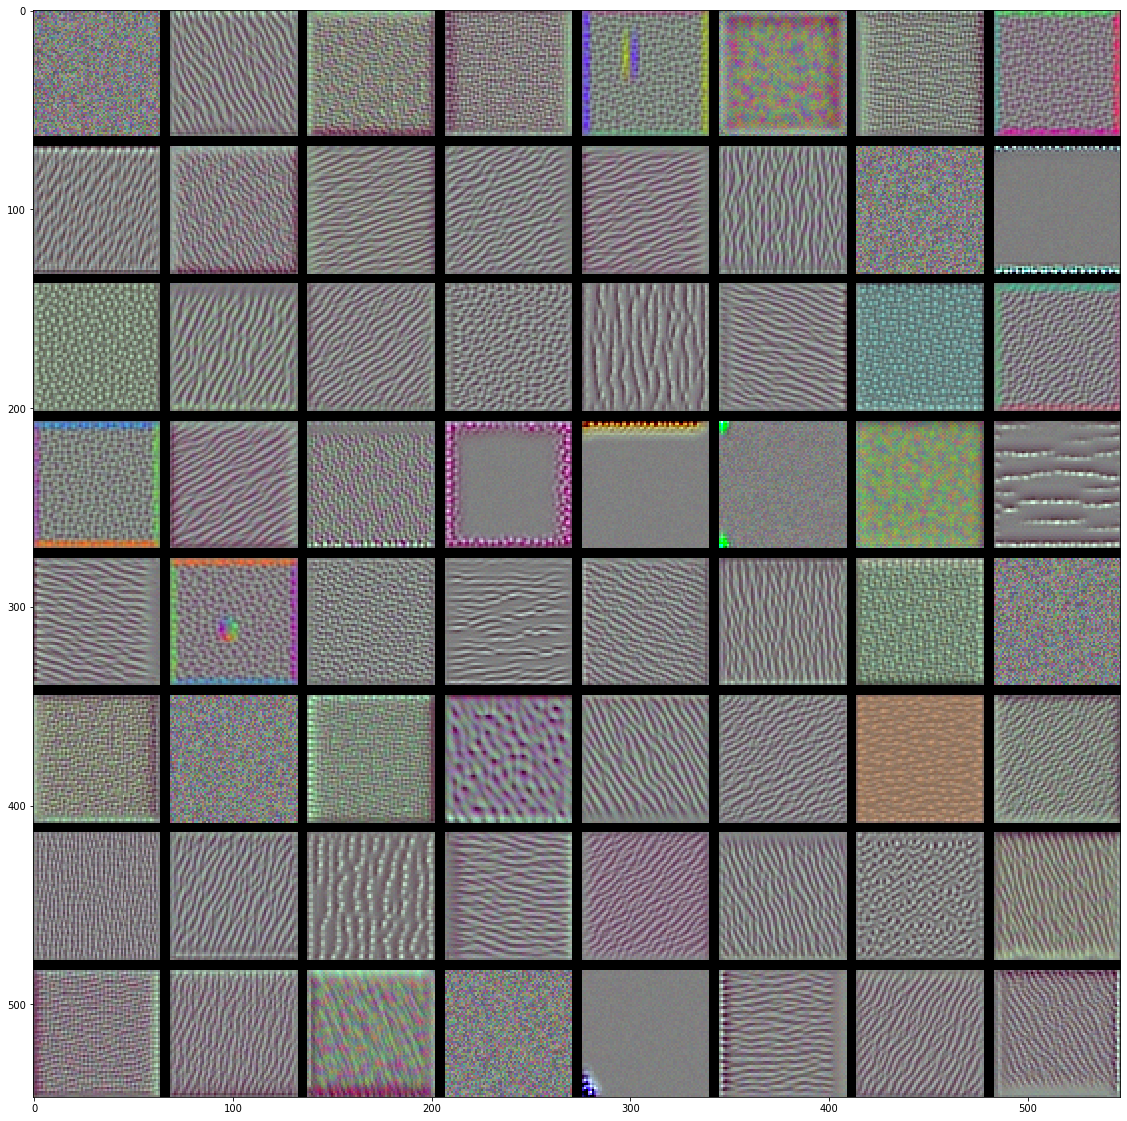

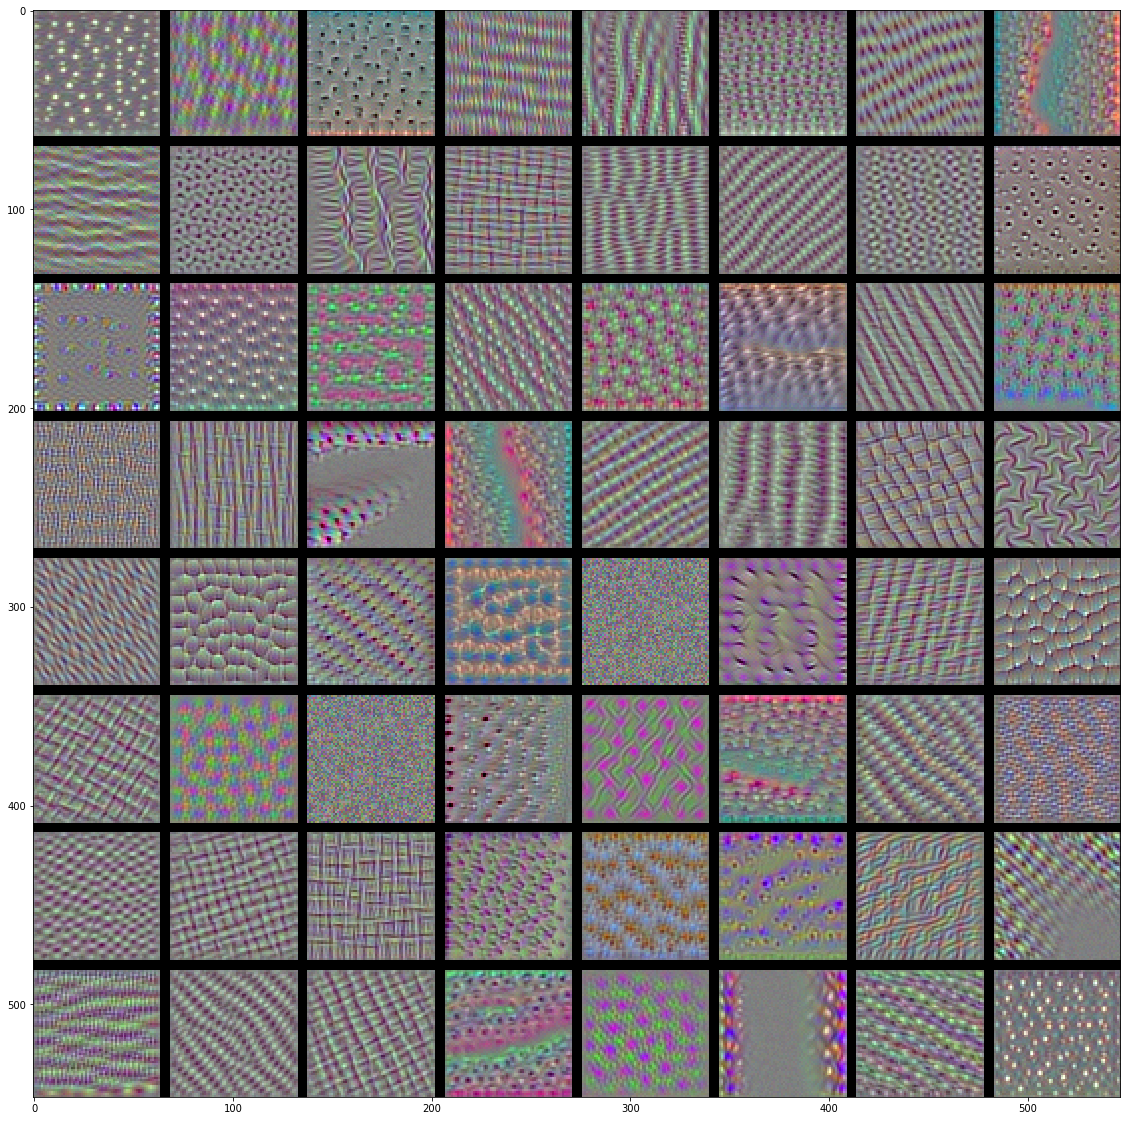

In [ ]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # 결과를 담을 빈 (검은) 이미지
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):  # results 그리드의 행을 반복합니다
        for j in range(8):  # results 그리드의 열을 반복합니다
            # layer_name에 있는 i + (j * 8)번째 필터에 대한 패턴 생성합니다
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # results 그리드의 (i, j) 번째 위치에 저장합니다
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # results 그리드를 그립니다
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

이런 필터 시각화를 통해 컨브넷 층이 바라보는 방식을 이해할 수 있습니다. 컨브넷의 각 층은 필터의 조합으로 입력을 표현할 수 있는 일련의 필터를 학습합니다. 이는 푸리에 변환을 사용해 신호를 일련의 코사인 함수로 분해할 수 있는 것과 비슷합니다. 이 컨브넷 필터들은 모델의 상위 층으로 갈수록 점점 더 복잡해지고 개선됩니다.

* 모델에 있는 첫 번째 층(`block1_conv1`)의 필터는 간단한 대각선 방향의 에지와 색깔(또는 어떤 경우에 색깔이 있는 에지)을 인코딩합니다.
* `block2_conv1`의 필터는 에지나 색깔의 조합으로 만들어진 간단한 질감을 인코딩합니다.
* 더 상위 층의 필터는 깃털, 눈, 나뭇잎 등과 같은 자연적인 이미지에서 찾을 수 있는 질감을 닮아가기 시작합니다.